<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Definições-Iniciais" data-toc-modified-id="Definições-Iniciais-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Definições Iniciais</a></span></li><li><span><a href="#Lendo-e-Analisando-Base" data-toc-modified-id="Lendo-e-Analisando-Base-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lendo e Analisando Base</a></span></li><li><span><a href="#Modelagem" data-toc-modified-id="Modelagem-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modelagem</a></span><ul class="toc-item"><li><span><a href="#Undersampling" data-toc-modified-id="Undersampling-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Undersampling</a></span></li><li><span><a href="#Oversampling" data-toc-modified-id="Oversampling-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Oversampling</a></span></li></ul></li></ul></div>

Este notebook é responsável por alocar o desenvolvimento e a investigação de um conjunto de dados do [Kaggle](https://www.kaggle.com/) contendo informações sobre transações de cartões de crédito para [identificação de fraude](https://www.kaggle.com/mlg-ulb/creditcardfraud).

No contexto desse problema de identificação de transações fraudulentas relacionadas ao uso de cartões de crédito, temos um conjunto de dados exemplificando transações realizadas durante dois dias de Setembro de 2013 por titulares europeus. Os dados foram coletados apresentam 492 transações fraudulentas em um total de 284.807 amostras. Isto mostra que o conjunto é altamente desbalanceado, apresentando exemplos da classe positiva (fraude) em apenas 0.172% do total de transações.

Além disso, temos um total 30 features onde 28 delas foram geradas a partir de um procedimento de PCA e, por critérios de segurança e sigilo, não foram providas informações adicionais sobre as mesmas. As duas features restantes representam, respectivamente:

* **Time:** Segundos entre cada transação e a primeira transação do dataset;
* **Amount:** Valor da transação.

Para avaliação do modelo, é recomendado o uso de AUC ROC (Area Under the Curve - ROC), uma vez que a própria matriz de confusão não é uma boa forma de avaliar modelos desbalanceados.

# Definições Iniciais

In [1]:
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time

# Utilidades
from utils.viz_utils import *
from utils.ml_utils import *
from utils.custom_transformers import *

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelagem
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, cross_val_predict, \
                                    learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, \
    accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Lendo e Analisando Base

In [2]:
# Caminho da base
path = r'D:\Users\thiagoPanini\Downloads\Datasets\kgl_CreditCard_FraudDetection'
df_ori = import_data(path + r'\creditcard.csv', optimized=True)
df_ori.columns = [col.lower() for col in df_ori.columns]

# Visualizando
print(f'Dimensões da base: {df_ori.shape}')
df_ori.head()

O dataset possui 31 colunas, das quais 31 são elegíveis a otimização.

----------------------------------------------------
Memória RAM utilizada (50 linhas): 0.0119 MB
Memória RAM após otimização (50 linhas): 0.0060 MB
----------------------------------------------------

Ganho de 50.32% em uso de memória!

Dimensões da base: (284807, 31)


,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.619995,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.690000,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.660004,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.500000,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798279,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.989998,0


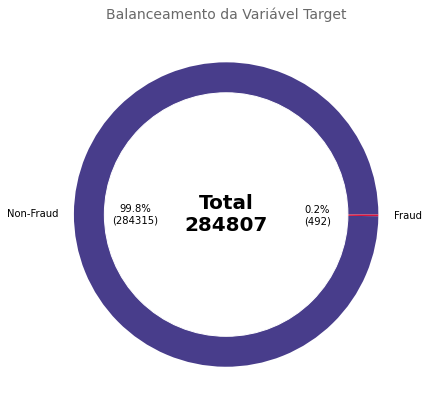

In [3]:
# Definindo parâmetros para visualizar balanceamento da base
fig, ax = plt.subplots(figsize=(7, 7))
label_names = ['Non-Fraud', 'Fraud']
color_list = ['darkslateblue', 'crimson']
text = f'Total\n{len(df_ori)}'
title = 'Balanceamento da Variável Target'

# Plotando gráfico
donut_plot(df_ori, col='class', ax=ax, label_names=label_names, colors=color_list, title=title, text=text)

___
* _Overview completo do conjunto_
___

In [4]:
# Analisando a base por completo
df_overview = data_overview(df_ori)
df_overview.head(20)

,feature,qtd_null,percent_null,dtype,qtd_cat
0,time,0,0.0,int32,0
1,v16,0,0.0,float32,0
2,amount,0,0.0,float32,0
3,v28,0,0.0,float32,0
4,v27,0,0.0,float32,0
5,v26,0,0.0,float32,0
6,v25,0,0.0,float32,0
7,v24,0,0.0,float32,0
8,v23,0,0.0,float32,0
9,v22,0,0.0,float32,0


___
* _Correlação com a variável target_
___

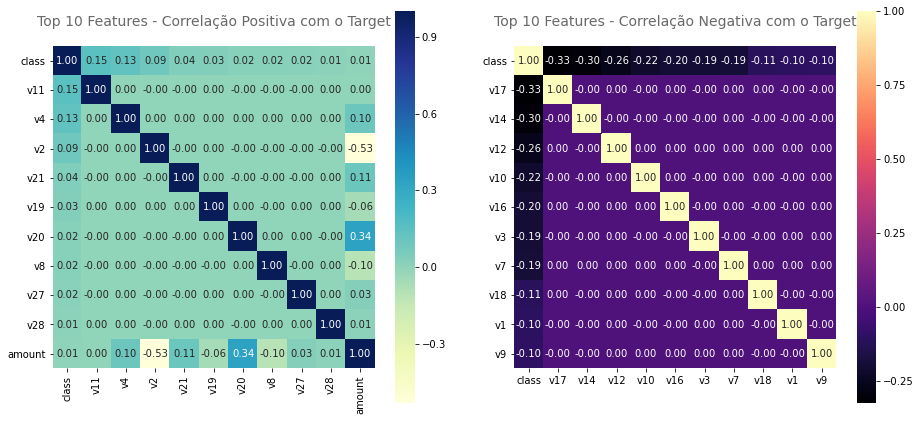

In [5]:
# Visualizando correlações positivas e negativas entre as features
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
target_correlation_matrix(data=df_ori, label_name='class', corr='positive', ax=axs[0])
target_correlation_matrix(data=df_ori, label_name='class', corr='negative', ax=axs[1])

plt.tight_layout()
plt.show()

___
* _Análise das variáveis numéricas da base_
___

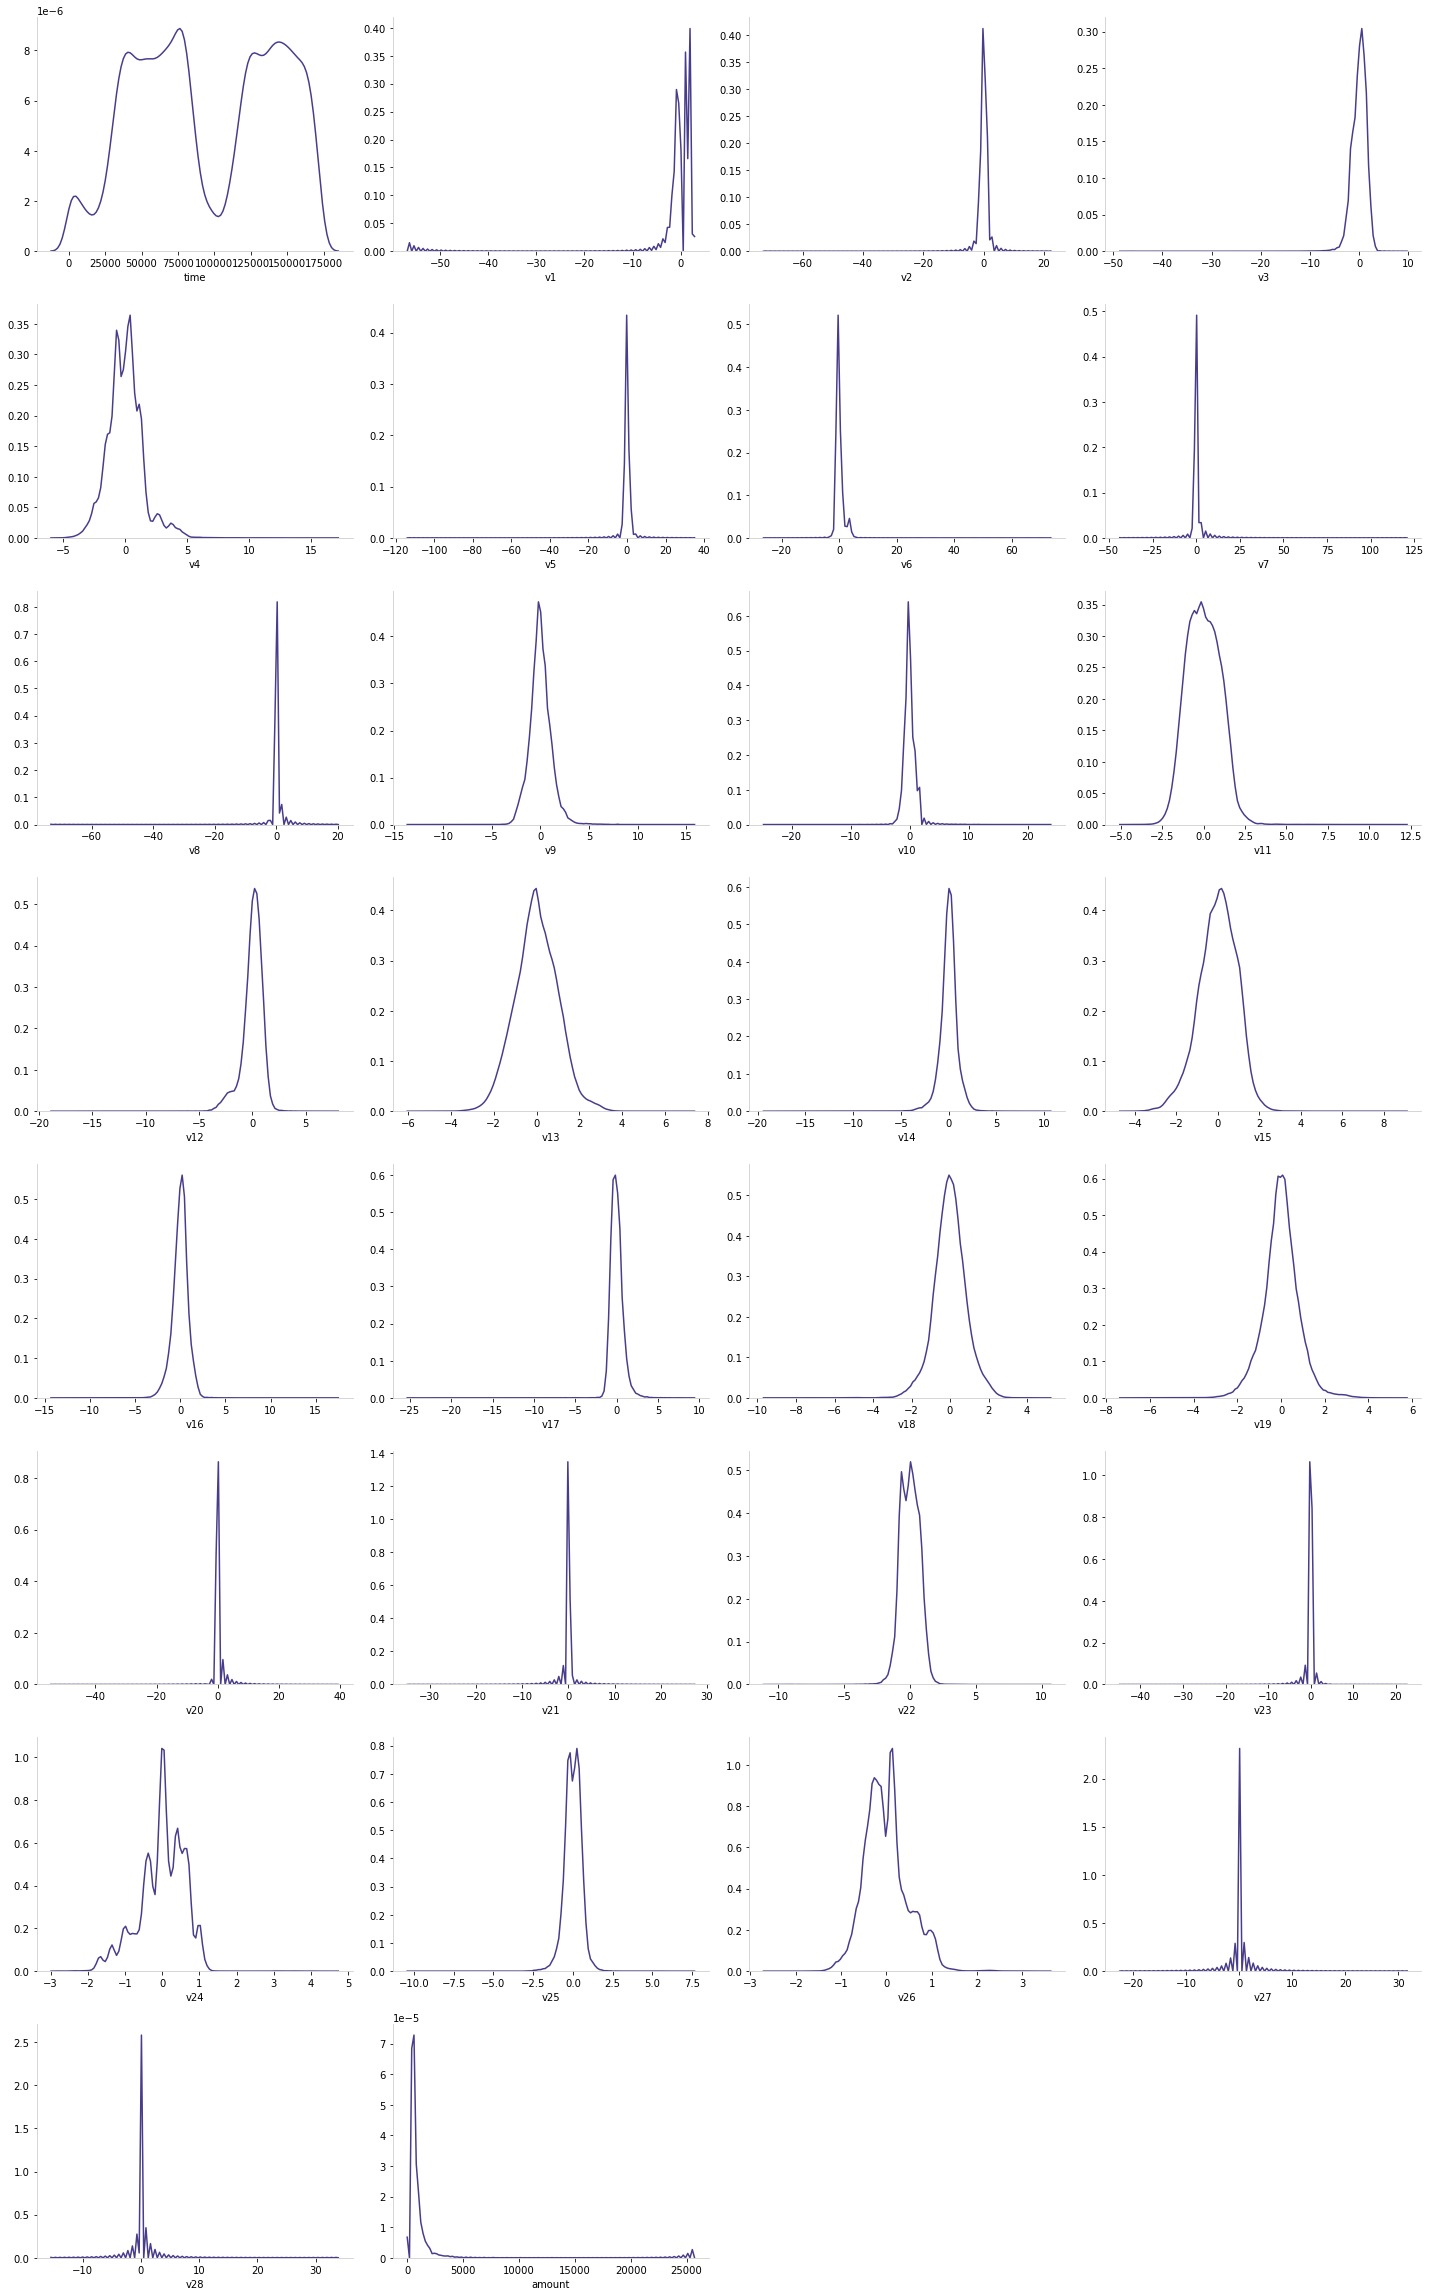

In [6]:
numplot_analysis(df_ori.drop('class', axis=1), fig_cols=4, color='darkslateblue')

___
* _Pipeline de pré-processamento dos dados_
___

In [7]:
# Features a serem utilizazdas no pipeline
features_ori = list(df_ori.drop('time', axis=1).columns)

In [8]:
# Construindo Pipeline de pré-processamento
pre_processing_pipe = Pipeline([
    ('selector', FeatureSelection(features=features_ori)),
    ('dup_dropper', DropDuplicates()),
    ('splitter', SplitData(target='class'))
])

# Executando Pipeline
X_train, X_test, y_train, y_test = pre_processing_pipe.fit_transform(df_ori)
model_features = list(X_train.columns)

# Verificando retorno
print(f'Dimensões de X_train: {X_train.shape}')
print(f'Dimensões de y_train: {y_train.shape}')
print(f'\nDimensões de X_test: {X_test.shape}')
print(f'Dimensões de y_test: {y_test.shape}')

Dimensões de X_train: (220530, 29)
Dimensões de y_train: (220530,)

Dimensões de X_test: (55133, 29)
Dimensões de y_test: (55133,)


In [9]:
# Separando atributos por tipo primitivo
num_attribs, cat_attribs = split_cat_num_data(X_train)
print(f'Quantidade de atributos numéricos: {len(num_attribs)}')
print(f'Quantidade de atributos categóricos: {len(cat_attribs)}')

Quantidade de atributos numéricos: 29
Quantidade de atributos categóricos: 0


# Modelagem

___
* _Modelo baseline: LightGBM_
___

In [10]:
# Preparando variáveis para alimentar classe
set_prep = {
    'X_train_prep': X_train.values,
    'X_test_prep': X_test.values,
    'y_train': y_train,
    'y_test': y_test
}

# Preparando classificador - LightGBM
lgbm_param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10),
}

lgbm_fixed_params = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 0
}

In [11]:
# Preparando set de classificadores
set_classifiers = {
    'LightGBM': {
        'model': lgb.LGBMClassifier(**lgbm_fixed_params),
        'params': lgbm_param_grid
    }
}

___
* _Treinando set de classificadores pré-definidos_
___

In [12]:
# Instanciando classe e treinando set de classificadores
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, cv=5)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


___
* _Avaliando performance em treino e teste_
___

In [13]:
# Retornando métricas do modelo
df_performances = clf_tool.evaluate_performance(X_train, y_train, X_test, y_test)
df_performances

,model,approach,acc,precision,recall,f1,auc,total_time
0,LightGBM,Treino 5 K-folds,0.9982,0.37,0.0131,0.025,0.9762,84.233
0,LightGBM,Teste,0.9983,0.00,0.0000,0.000,0.9632,0.625


___
* _Analisando features mais relevantes_
___

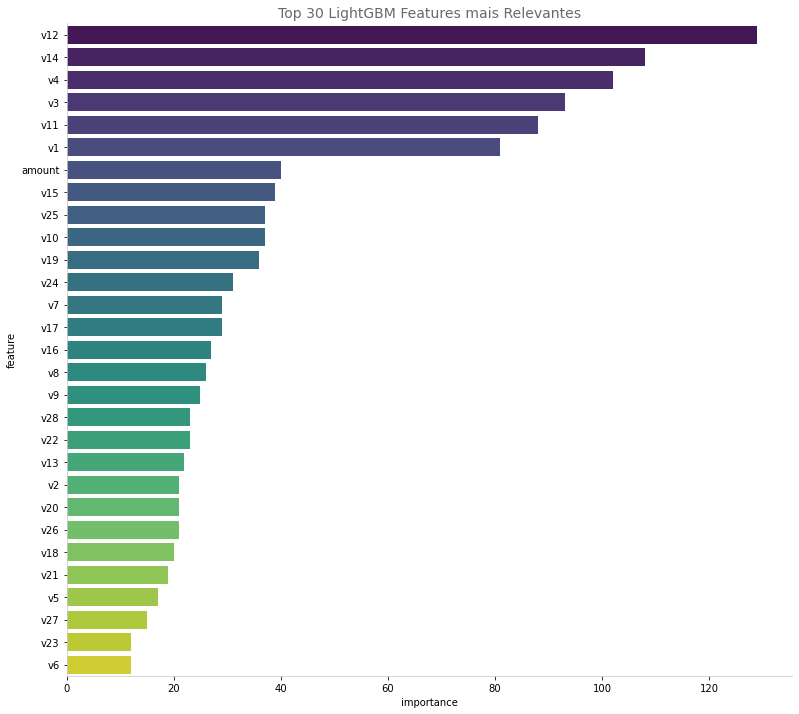

In [14]:
# Visualizando features mais importantes
fig, ax = plt.subplots(figsize=(13, 12))
lgbm_feature_importance = clf_tool.feature_importance_analysis(model_features, specific_model='LightGBM', ax=ax)
plt.show()

___
* _Visualizando curva ROC em treino e teste_
___

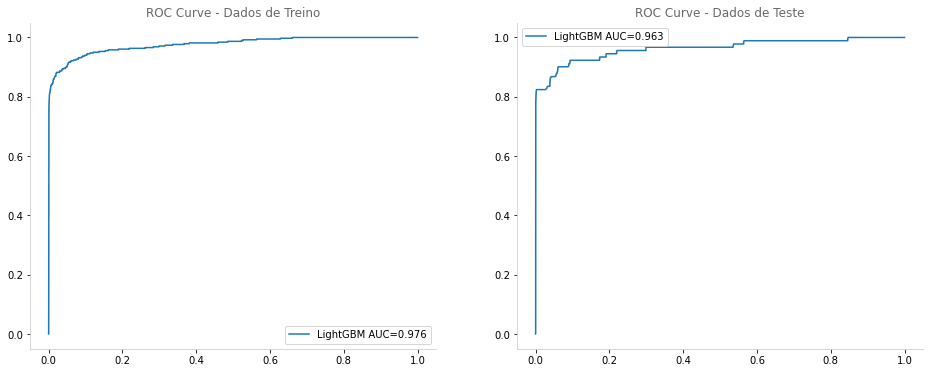

In [15]:
# Plotando curva ROC
clf_tool.plot_roc_curve()

___
* _Analisando distribuição dos scores em treino e teste_
___

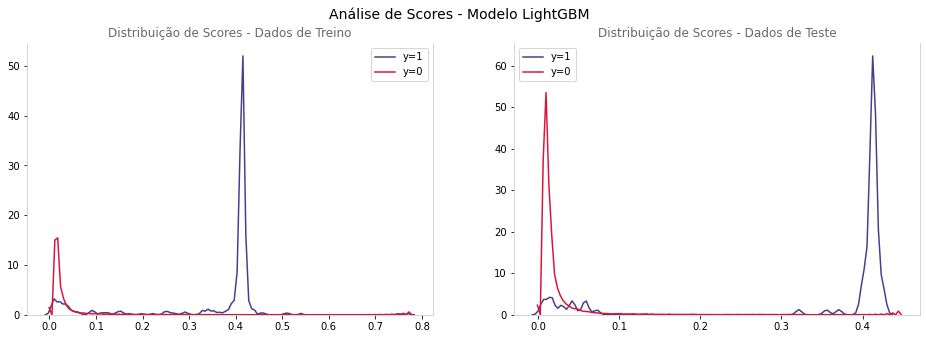

In [16]:
# Distribuição de scores
clf_tool.plot_score_distribution('LightGBM')

___
* _Analisando distribuição de scores_
___

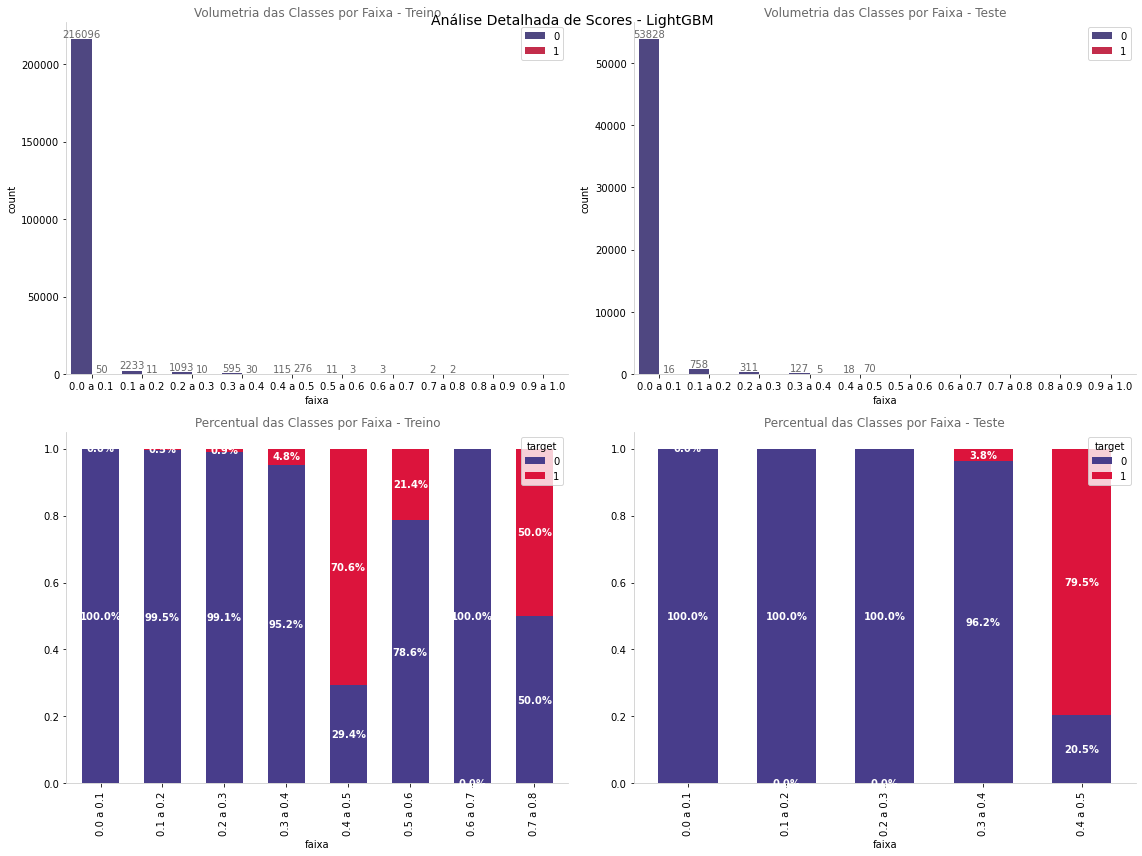

In [17]:
# Separação por faixa
clf_tool.plot_score_bins('LightGBM', bin_range=0.1)

## Undersampling

In [18]:
# Aplicando undersampling na base
rus = RandomUnderSampler()
X_train_under, y_train_under = rus.fit_sample(X_train, y_train)

# Treinando novo modelo após undersampling
undersamp_approach= '_undersamp'
clf_tool.fit(set_classifiers, X_train_under, y_train_under, random_search=True, cv=5, approach=undersamp_approach)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.9s finished


In [19]:
# Retornando métricas do modelo
df_performances = clf_tool.evaluate_performance(X_train_under, y_train_under, X_test, y_test)
df_performances

,model,approach,acc,precision,recall,f1,auc,total_time
0,LightGBM,Treino 5 K-folds,0.9982,0.3700,0.0131,0.0250,0.9762,84.233
0,LightGBM,Teste,0.9983,0.0000,0.0000,0.0000,0.9632,0.625
0,LightGBM_undersamp,Treino 5 K-folds,0.9345,0.9669,0.9005,0.9322,0.9792,3.809
0,LightGBM_undersamp,Teste,0.9722,0.0500,0.8791,0.0946,0.9735,0.604


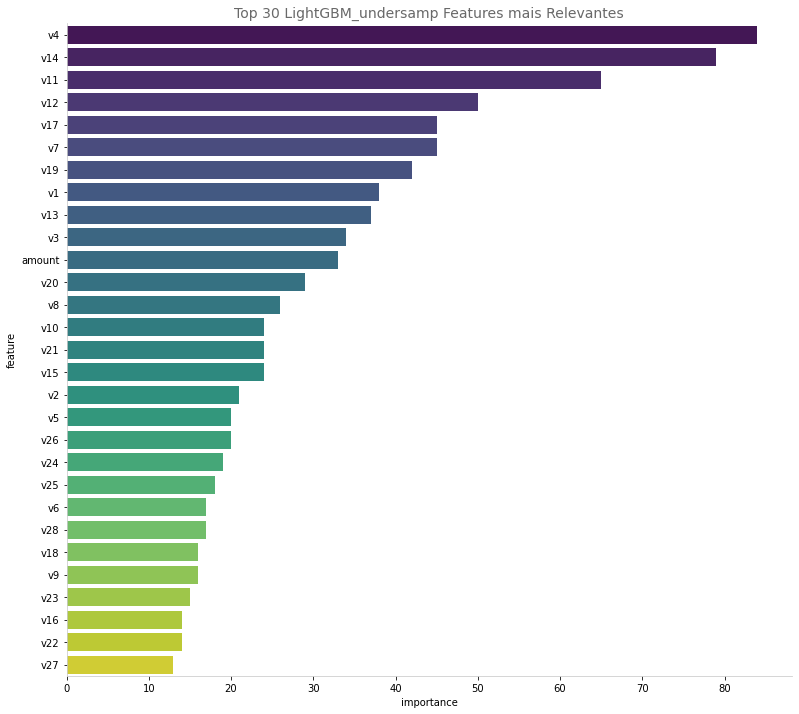

In [20]:
# Visualizando features mais importantes
fig, ax = plt.subplots(figsize=(13, 12))
lgbm_undersamp_feat_imp = clf_tool.feature_importance_analysis(model_features, specific_model='LightGBM_undersamp', ax=ax)
plt.show()

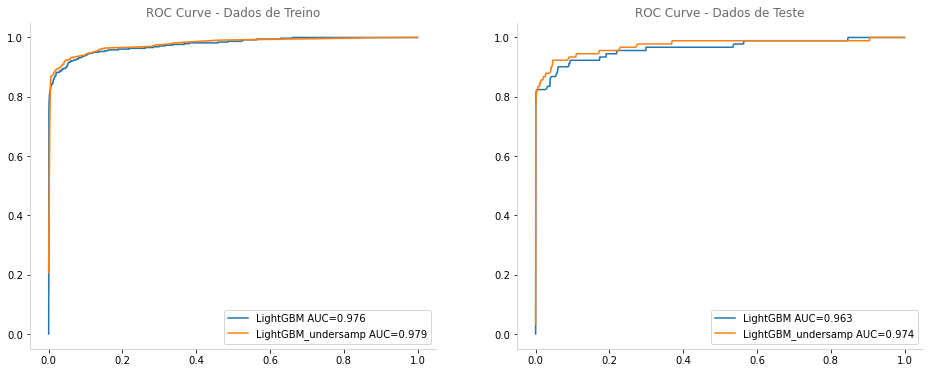

In [21]:
# Plotando curva ROC
clf_tool.plot_roc_curve()

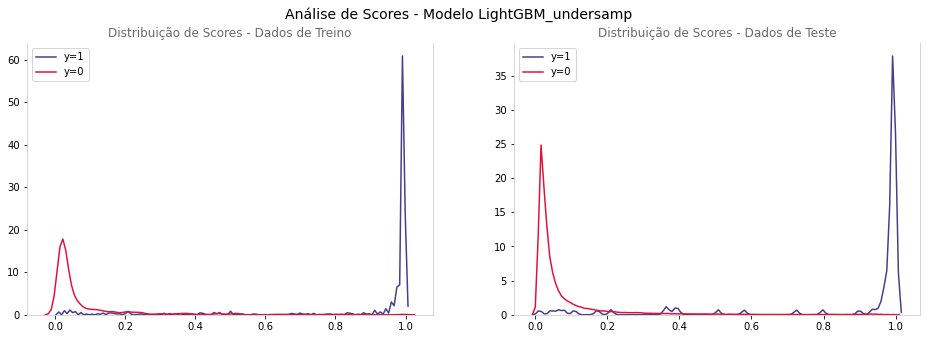

In [22]:
# Distribuição de scores
clf_tool.plot_score_distribution('LightGBM_undersamp')

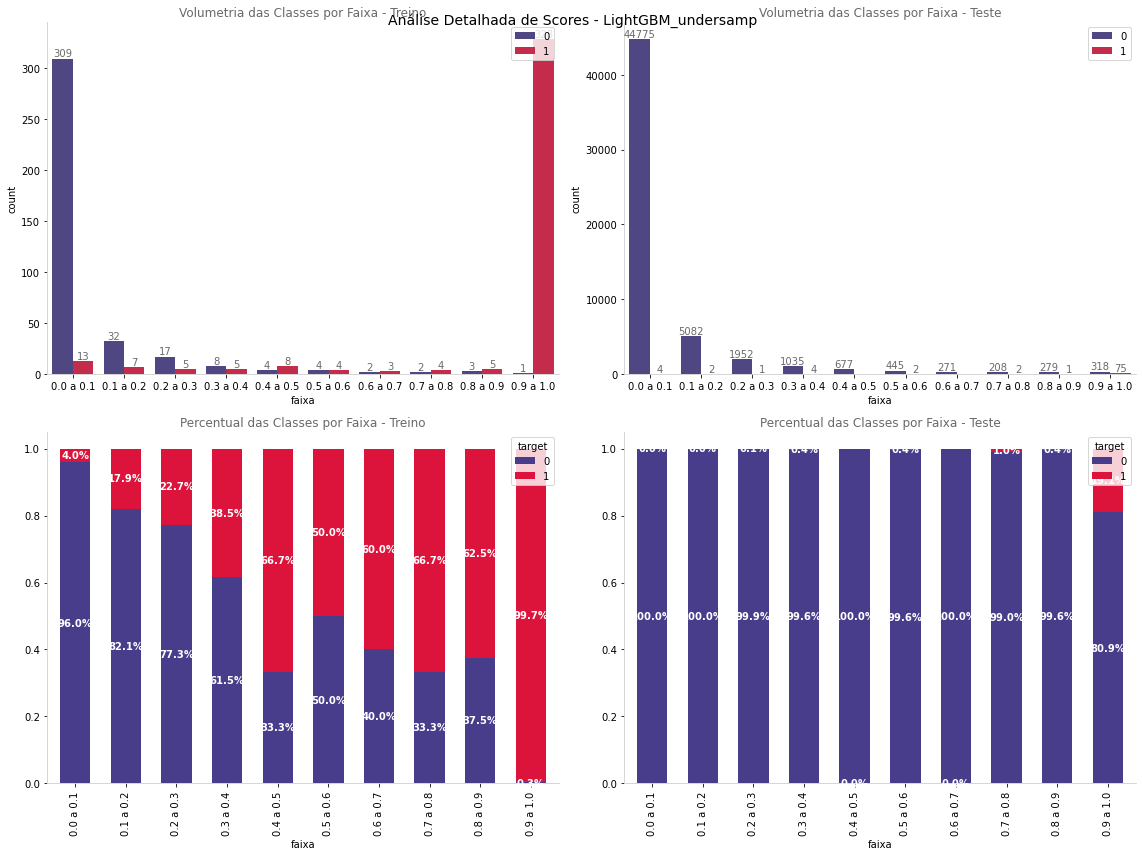

In [23]:
# Separação por faixa
clf_tool.plot_score_bins('LightGBM_undersamp', bin_range=0.1)

## Oversampling

In [24]:
# Aplicando undersampling na base
sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_over, y_train_over = sm.fit_sample(X_train, y_train)

# Treinando novo modelo após undersampling
oversamp_approach= '_oversamp'
clf_tool.fit(set_classifiers, X_train_over, y_train_over, random_search=True, cv=5, approach=oversamp_approach)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


In [25]:
# Retornando métricas do modelo
df_performances = clf_tool.evaluate_performance(X_train_over, y_train_over, X_test, y_test)
df_performances

,model,approach,acc,precision,recall,f1,auc,total_time
0,LightGBM,Treino 5 K-folds,0.9982,0.3700,0.0131,0.0250,0.9762,84.233
0,LightGBM,Teste,0.9983,0.0000,0.0000,0.0000,0.9632,0.625
0,LightGBM_undersamp,Treino 5 K-folds,0.9345,0.9669,0.9005,0.9322,0.9792,3.809
0,LightGBM_undersamp,Teste,0.9722,0.0500,0.8791,0.0946,0.9735,0.604
0,LightGBM_oversamp,Treino 5 K-folds,0.9983,0.9981,0.9986,0.9983,0.9999,194.977
0,LightGBM_oversamp,Teste,0.9978,0.4130,0.8352,0.5527,0.9790,0.784


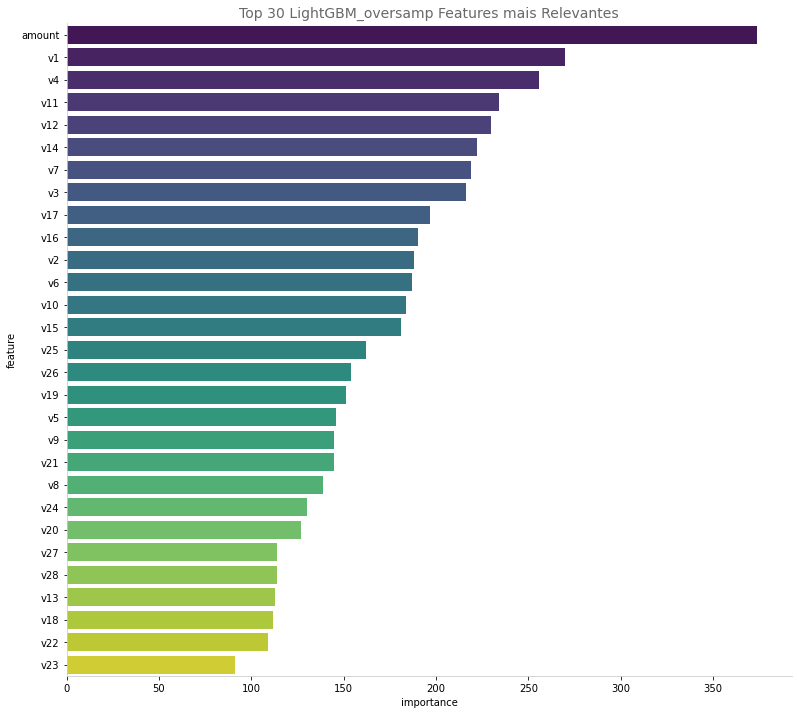

In [26]:
# Visualizando features mais importantes
fig, ax = plt.subplots(figsize=(13, 12))
lgbm_oversamp_feat_imp = clf_tool.feature_importance_analysis(model_features, specific_model='LightGBM_oversamp', ax=ax)
plt.show()

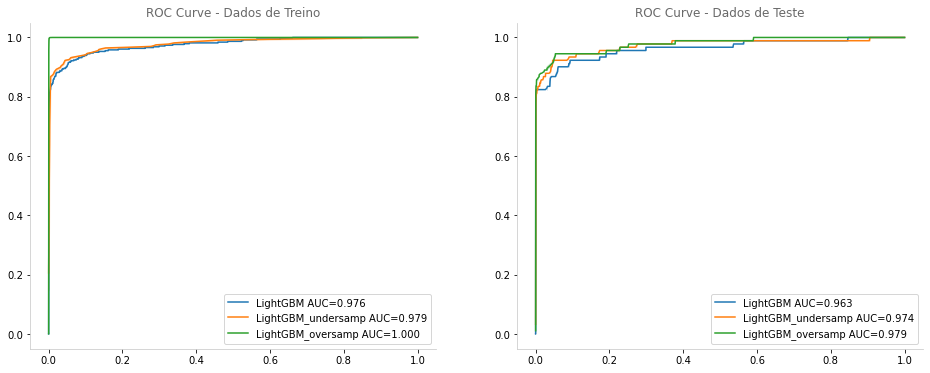

In [27]:
# Plotando curva ROC
clf_tool.plot_roc_curve()

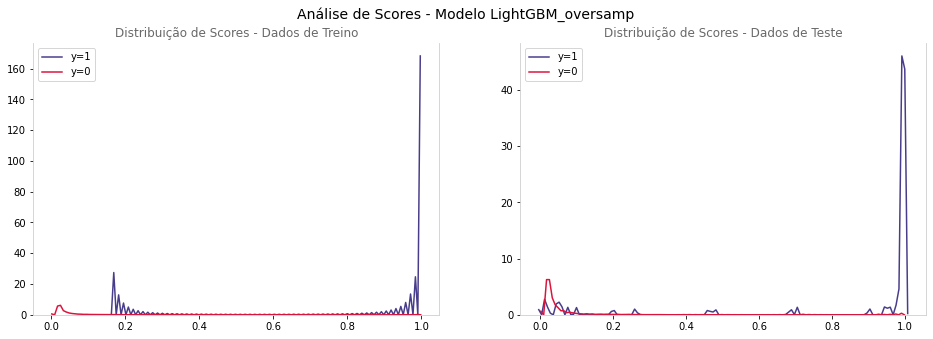

In [28]:
# Distribuição de scores
clf_tool.plot_score_distribution('LightGBM_oversamp')

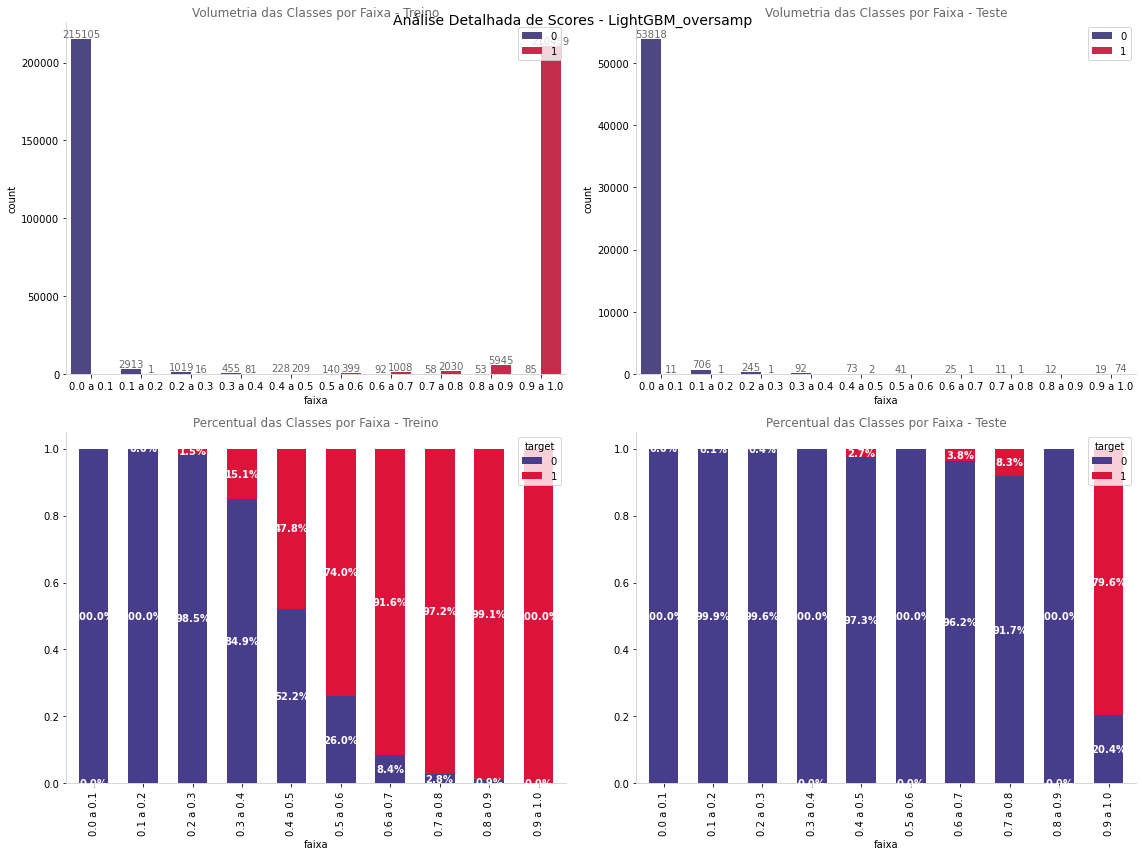

In [29]:
# Separação por faixa
clf_tool.plot_score_bins('LightGBM_oversamp', bin_range=0.1)